In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (update the path as needed)
file_path = "/content/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# Clean column names to remove leading/trailing spaces
df.columns = df.columns.str.strip()

# Check if 'Humanitarian_Class' exists
if "Humanitarian_Class" not in df.columns:
    raise KeyError("Column 'Humanitarian_Class' not found in the dataset. Please check the column names.")

# Perform stratified splitting based on 'Humanitarian_Class' (5 classes)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Humanitarian_Class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Humanitarian_Class"], random_state=42)

# Save the split datasets
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

# Create a structured summary table
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Humanitarian_Class"].value_counts(),
    "Validation (15%)": val_df["Humanitarian_Class"].value_counts(),
    "Test (15%)": test_df["Humanitarian_Class"].value_counts(),
    "Total": df["Humanitarian_Class"].value_counts()
}).T

# Save the summary table
split_summary.to_csv("split_summary.csv")

print("Data split completed and saved as CSV files.")

Data split completed and saved as CSV files.


Loading FastText model...
[==================================================] 100.0% 958.5/958.4MB downloaded
Generating FastText embeddings...


100%|██████████| 2713/2713 [00:00<00:00, 38109.48it/s]


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best RandomForest Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best RandomForest model saved.
Final Model Accuracy: 0.6860
Classification Report:
                                         precision    recall  f1-score   support

                  affected_individuals       0.67      0.55      0.61       163
rescue_volunteering_or_donation_effort       0.74      0.72      0.73       567
     infrastructure_and_utility_damage       0.68      0.51      0.58       224
            other_relevant_information       0.65      0.73      0.69       975
                      not_humanitarian       0.70      0.69      0.69       784

                              accuracy                           0.69      2713
                             macro avg       0.69      0.64      0.66      2713
                          weighted avg       0.69      0.69      0.68      2713



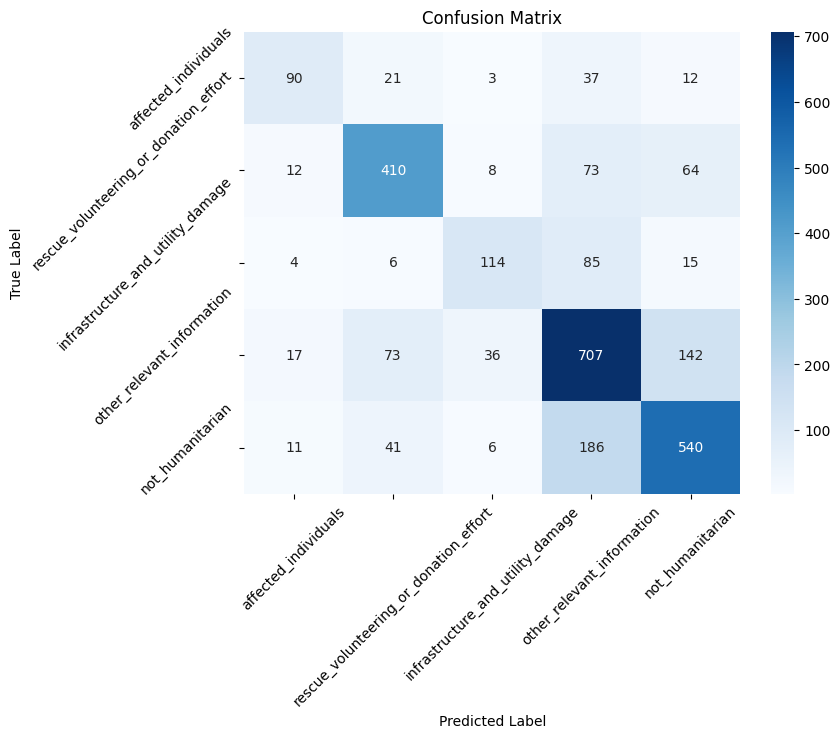

In [ ]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import Counter
import gensim.downloader as api
from tqdm import tqdm

# ========== Load FastText ==========
print("Loading FastText model...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

# ========== Load Data ==========
train_path = "/content/train_data.csv"
val_path = "/content/val_data.csv"
test_path = "/content/test_data.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# ========== Normalize column names ==========
for df in [train_df, val_df, test_df]:
    df.columns = df.columns.str.strip().str.lower()

# ========== Define label mapping ==========
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}

# ========== Preprocess Labels ==========
for df in [train_df, val_df, test_df]:
    df['humanitarian_class'] = df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower()

y_train = train_df['humanitarian_class'].map(label_map).astype(int)
y_test = test_df['humanitarian_class'].map(label_map).astype(int)

# ========== Fill missing Processed Data ==========
for df in [train_df, test_df]:
    df['processed_data'] = df['processed_data'].fillna("")

# ========== FastText Embedding Function ==========
def get_avg_embedding(text, model, dim=300):
    words = text.split()
    embeddings = [model[word] for word in words if word in model]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(dim)

# ========== Generate FastText Vectors ==========
print("Generating FastText embeddings...")
X_train_embed = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(train_df['processed_data'])])
X_test_embed = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(test_df['processed_data'])])

# ========== Feature Engineering ==========
for df in [train_df, test_df]:
    df['tweet_length'] = df['processed_data'].apply(len)
    df['num_hashtags'] = df['processed_data'].apply(lambda x: x.count("#"))
    df['num_mentions'] = df['processed_data'].apply(lambda x: x.count("@"))

scaler = StandardScaler()
X_train_features = scaler.fit_transform(train_df[['tweet_length', 'num_hashtags', 'num_mentions']])
X_test_features = scaler.transform(test_df[['tweet_length', 'num_hashtags', 'num_mentions']])

# ========== Combine FastText + Numerical Features ==========
X_train_combined = np.hstack((X_train_embed, X_train_features))
X_test_combined = np.hstack((X_test_embed, X_test_features))

# ========== Apply SMOTE ==========
max_class_samples = max(Counter(y_train).values())
sampling_strategy = {label: max_class_samples for label in np.unique(y_train)}

smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

# ========== Hyperparameter Tuning ==========
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=10, cv=3,
    scoring='accuracy', n_jobs=-1, verbose=2, random_state=42
)
random_search.fit(X_train_resampled, y_train_resampled)

# ========== Train Best Model ==========
best_rf = random_search.best_estimator_
print("Best RandomForest Parameters:", random_search.best_params_)

best_rf.fit(X_train_resampled, y_train_resampled)
joblib.dump(best_rf, "random_forest_best.pkl")
print("Best RandomForest model saved.")

# ========== Predict & Evaluate ==========
y_pred = best_rf.predict(X_test_combined)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=label_map.keys())
print(f'Final Model Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_rep)

# ========== Confusion Matrix ==========
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
